# Modeling

This notebook contains the code that performs feature engineering, modeling, and model explainer.

Data Provided by Department of Transportation (DOT)

Dataset Owner NYC OpenData

### Load Packages and Set Environment

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()
import re

import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

### User Defined Functions

In [2]:
# Only should be used for temperature and preciptation since they the times are in order.
# Locates null values and takes average between preceeding and following value
def null_filler(df, column):
    null_indexes = df[column][df[column].isnull()].index
    
    for i in null_indexes:
        if i == (df.shape[1] - 1):
            df[column][i] = df[column][i-1]
        elif i == 0:
            df[column][i] = df[column][i+1]
        else:
            df[column][i] = (df[column][i-1] + df[column][i+1])/2
            
    return df[column]


### Load Data

In [3]:
data = pd.read_csv('Brooklyn_Bridge_Automated_Pedestrian_Counts_Demonstration_Project.csv')

In [4]:
data_profiler = pd.DataFrame(data = data.columns, columns = ['columns'])
data_profiler['dtype'] = data.dtypes.values
data_profiler['unique_values'] = data.nunique().values
data_profiler['nulls'] = data.isnull().sum().values

In [5]:
unique_values = data_profiler.loc[data_profiler['unique_values'] > 1,'columns'].values
data_trim = data.loc[:, unique_values]

## Feature Engineering

### Date Extractions

In [6]:
data_trim['hour_beginning_dt'] = pd.to_datetime(data_trim['hour_beginning'])
data_trim['year'] = data_trim['hour_beginning_dt'].apply(lambda x: x.year)
data_trim['month'] = data_trim['hour_beginning_dt'].apply(lambda x: x.month)
data_trim['day'] = data_trim['hour_beginning_dt'].apply(lambda x: x.day)
data_trim['hour'] = data_trim['hour_beginning_dt'].apply(lambda x: x.hour)
data_trim['year_month'] = data_trim['hour_beginning_dt'].apply(lambda x: str(x.year).zfill(4) + '-' + str(x.month).zfill(2))
data_trim['date'] = data_trim['hour_beginning_dt'].apply(lambda x: x.date())
data_trim['day_of_week'] = data_trim['hour_beginning_dt'].apply(lambda x: x.weekday())

### Events One-Hot Encoding

In [7]:
event_dummies = pd.get_dummies(data = data_trim['events'])
data_trim = pd.concat([data_trim, event_dummies], axis=1)

### Weather-Related Features

In [8]:
# Fill in nulls for these columns
data_trim['temperature'] = null_filler(data_trim, 'temperature')
data_trim['precipitation'] = null_filler(data_trim, 'precipitation')

In [9]:
# Differences in temperature, is it a good day ? :)
daily_temperatures = data_trim.groupby('date').agg({'temperature': 'max'}).reset_index()
daily_temperatures.rename(columns={'temperature': 'daily_high'}, inplace = True)
daily_temperatures['daily_temp_chang_1'] = daily_temperatures['daily_high'].pct_change(periods=1)
daily_temperatures['daily_temp_chang_3'] = daily_temperatures['daily_high'].pct_change(periods=3)
daily_temperatures['daily_temp_chang_5'] = daily_temperatures['daily_high'].pct_change(periods=5)
daily_temperatures = daily_temperatures.fillna(0)

data_trim = data_trim.merge(daily_temperatures, on = 'date')

In [10]:
data_trim['weather_summary'] = data_trim['weather_summary'].fillna('')
data_trim['clear'] = data_trim['weather_summary'].apply(lambda x: 1 if bool(re.search("clear", x)) else 0)
data_trim['night'] = data_trim['weather_summary'].apply(lambda x: 1 if bool(re.search("night", x)) else 0)
data_trim['day'] = data_trim['weather_summary'].apply(lambda x: 1 if bool(re.search("day", x)) else 0)
data_trim['partly_cloudy'] = data_trim['weather_summary'].apply(lambda x: 1 if bool(re.search("partly", x)) else 0)
data_trim['rain'] = data_trim['weather_summary'].apply(lambda x: 1 if bool(re.search("rain", x)) else 0)
data_trim['windy'] = data_trim['weather_summary'].apply(lambda x: 1 if bool(re.search("wind", x)) else 0)
data_trim['fog'] = data_trim['weather_summary'].apply(lambda x: 1 if bool(re.search("fog", x)) else 0)
data_trim['snow'] = data_trim['weather_summary'].apply(lambda x: 1 if bool(re.search("snow", x)) else 0)
data_trim['sleet'] = data_trim['weather_summary'].apply(lambda x: 1 if bool(re.search("sleet", x)) else 0)

In [11]:
new_col = []
for col in data_trim.columns:
    a = col.replace("'",'')
    a = a.replace(" ", "_")
    a = a.replace(".", "")
    a = a.replace('(', "")
    a = a.replace(')', "")
    a = a.lower()
    new_col.append(a)
    
data_trim.columns = new_col

In [12]:
data_trim.head()

,hour_beginning,pedestrians,towards_manhattan,towards_brooklyn,weather_summary,temperature,precipitation,events,hour_beginning_dt,year,...,daily_temp_chang_3,daily_temp_chang_5,clear,night,partly_cloudy,rain,windy,fog,snow,sleet
0,10/01/2017 12:00:00 AM,44,30,14,clear-night,52.0,0.0001,NaN,2017-10-01 00:00:00,2017,...,0.0,0.0,1,1,0,0,0,0,0,0
1,10/01/2017 01:00:00 AM,30,17,13,partly-cloudy-night,53.0,0.0002,NaN,2017-10-01 01:00:00,2017,...,0.0,0.0,0,1,1,0,0,0,0,0
2,10/01/2017 02:00:00 AM,25,13,12,partly-cloudy-night,52.0,0.0000,NaN,2017-10-01 02:00:00,2017,...,0.0,0.0,0,1,1,0,0,0,0,0
3,10/01/2017 03:00:00 AM,20,11,9,partly-cloudy-night,51.0,0.0000,NaN,2017-10-01 03:00:00,2017,...,0.0,0.0,0,1,1,0,0,0,0,0
4,10/01/2017 04:00:00 AM,18,10,8,partly-cloudy-night,51.0,0.0000,NaN,2017-10-01 04:00:00,2017,...,0.0,0.0,0,1,1,0,0,0,0,0


### Modeling

In [13]:
X =  data_trim[['pedestrians', 'temperature', 'precipitation', 'month', 'hour', 'day_of_week',
               'black_friday', 'christmas_day', 'christmas_eve', 'cinco_de_mayo',
       'columbus_day_regional_holiday', 'daylight_saving_time_ends',
       'daylight_saving_time_starts', 'easter_sunday', 'fathers_day',
       'halloween', 'independence_day', 'martin_luther_king_jr_day',
       'memorial_day', 'mothers_day', 'new_years_day', 'new_years_eve',
       'presidents_day_regional_holiday', 'st_patricks_day', 'tax_day',
       'thanksgiving_day', 'valentines_day', 'veterans_day',
       'veterans_day_observed', 'daily_high', 'daily_temp_chang_1',
       'daily_temp_chang_3', 'daily_temp_chang_5', 'clear', 'night',
       'partly_cloudy', 'rain', 'windy', 'fog', 'snow', 'sleet'
               ]].fillna(0)
y = X.pop('pedestrians')
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_summary = shap.kmeans(X_train, 10)

In [14]:
rforest = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=4, random_state=0, n_jobs = -1)
rforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [15]:
print("Training MSE", mean_squared_error(y_train, rforest.predict(X_train)))
print("Validation MSE", mean_squared_error(y_test, rforest.predict(X_test)))

Training MSE 6333.211461047598
Validation MSE 29514.695590448442


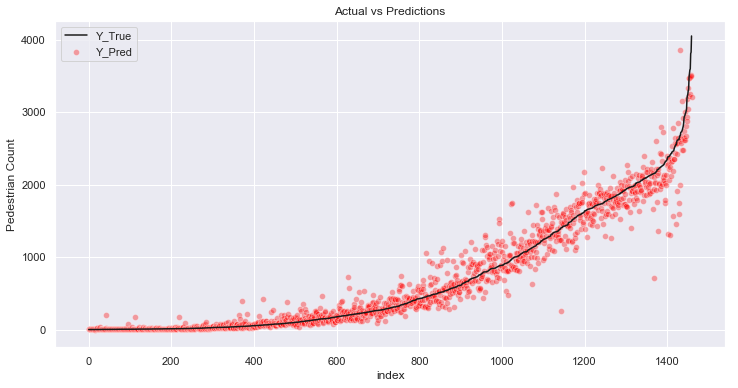

In [16]:
# Error Plot
y_pred = rforest.predict(X_test)
y_true = y_test.reset_index(drop = True)

preds_df = pd.DataFrame([y_true, y_pred]).T
preds_df.columns = ['y_true', 'y_pred']
preds_df = preds_df.sort_values('y_true').reset_index(drop = True)
preds_df = preds_df.reset_index(drop = False)

figure, ax = plt.subplots(ncols = 1, figsize = (12,6))
g = sns.lineplot(x = 'index', y = 'y_true', data = preds_df, alpha = 1, label = 'Y_True', color = 'k')
g = sns.scatterplot(x = 'index', y = 'y_pred', data = preds_df, alpha = .35, label = 'Y_Pred', color = 'red')
plt.title('Actual vs Predictions')
plt.ylabel('Pedestrian Count')
plt.show()

In [17]:
# explain all the predictions in the test set
explainer = shap.TreeExplainer(rforest)
shap_values = explainer.shap_values(X_test)

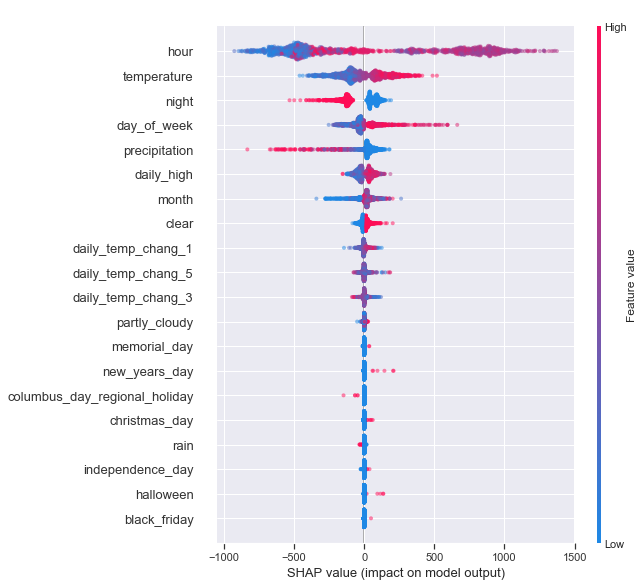

In [18]:
shap.summary_plot(shap_values, X_test, alpha = .5)